In [24]:
#imports
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
from math import sin, cos, sqrt, atan2, radians

def get_distance(lat1, lon1, lat2, lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return round(distance, 2)

In [3]:
data = pd.read_csv('../data/2018/201801-citibike-tripdata.csv')

In [4]:
# transforming data to get 'distance' column
s = time.time()
distances = [0] * len(data)

for i, row in data.iterrows():
    distances[i] = get_distance(row["start station latitude"], row["start station longitude"], row["end station latitude"], row["end station longitude"])

data["distance"] = pd.Series(distances)
print(time.time() - s)

126.57759428024292


In [5]:
del data["starttime"]
del data["stoptime"]
del data["start station id"]
del data["start station name"]
del data["end station id"]
del data["end station name"]
del data["bikeid"]
del data["start station latitude"]
del data["start station longitude"]
del data["end station latitude"]
del data["end station longitude"]

In [6]:
print(len(data))

718994


In [7]:
del data["usertype"]
del data["birth year"]
del data["gender"]

In [8]:
data.head(1)

,tripduration,distance
0,970,2.08


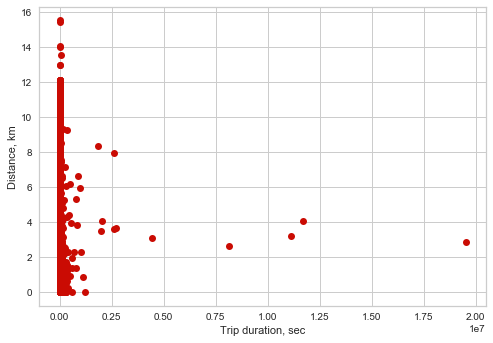

In [59]:
plt.plot(data["tripduration"], data["distance"], 'ro')
plt.ylabel('Distance, km')
plt.xlabel('Trip duration, sec')
plt.savefig("./original_data.png", )
plt.show()

From this plot we cannot directly tell if there is any dependence between x and y because there are some outliers that prevent us from conclusions. The biggest value is nearly equal to 7.5 months of ride and there are other huge values. As we cannot deal with these large numbers we could delete them from our data.

In [61]:
data1 = data[data.tripduration <= 3600]

In [62]:
data1.head(5)

,tripduration,distance
0,970,2.08
1,723,1.86
2,496,1.44
3,306,0.84
4,306,1.13


We left entries where time of ride was smaller then 1 hour. If time was bigger - we do not include that entry. There are only 0.3% of such entries.

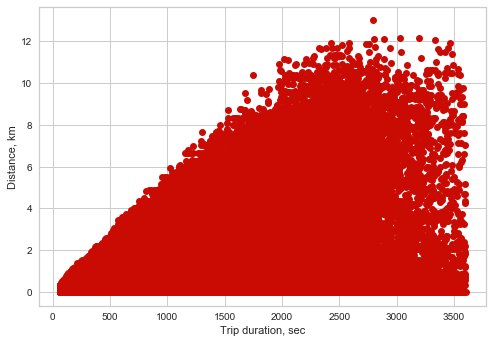

In [63]:
plt.plot(data1["tripduration"], data1["distance"], 'ro')
plt.ylabel('Distance, km')
plt.xlabel('Trip duration, sec')
plt.savefig("./hour_data.png", )
plt.show()

In [64]:
k = int(0.8*len(data1))
print(k)
x_train = data1["tripduration"][:k]
x_test = data1["tripduration"][k:]
y_train = data1["distance"][:k]
y_test = data1["distance"][k:]

573256


In [65]:
model = LinearRegression()

model.fit(list(map(lambda x:[x],x_train)), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [66]:
predict = model.predict(list(map(lambda x:[x],x_test)))

In [74]:
y1 = predict - y_test

In [67]:
model.score(list(map(lambda x:[x],x_train)), y_train)

0.6104598781041051

In [73]:
model.score(list(map(lambda x:[x],x_test)), y_test)

0.6138695831960952

### Scatter plot of the data

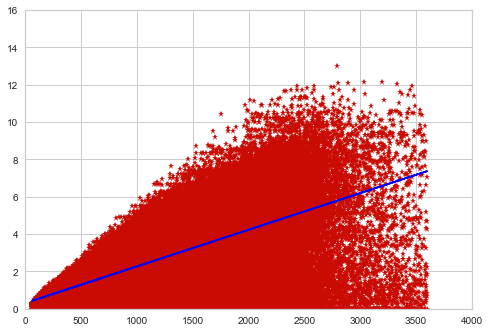

In [70]:
plt.plot(data1["tripduration"], data1["distance"], 'r*')
plt.plot(x_test, predict, color="blue")
plt.axis([0, 4000, 0, 16])
plt.savefig("./data_line.png", )
plt.show()

As we can see from the plot there is a lot of scatter around the data, so it is more probable that there is no linearity

### Residuals plot and histogram

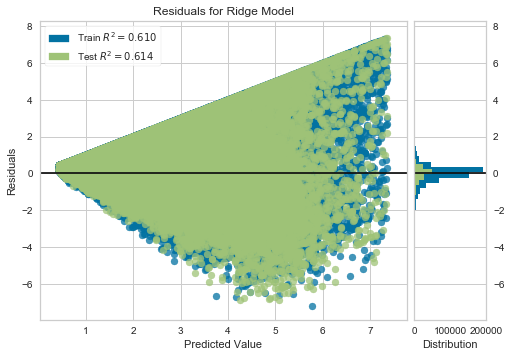

In [71]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(list(map(lambda x:[x],x_train)), y_train)  # Fit the training data to the model
visualizer.score(list(map(lambda x:[x],x_test)), y_test)  # Evaluate the model on the test data
visualizer.poof()

As we can see from residuals plot, variability of residuals around 0 is not constant. As x increases, y increses as well. 

### Normal probability plot of residuals

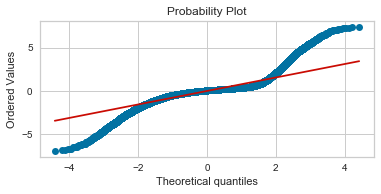

In [75]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(y1, plot=ax, fit=True)